# Store large numpy array using tables, storing similarity matrix, Pandas merge, Matplotlib, Pandas rename

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd
import cv2
import sys  
sys.path.insert(0, '/home/pytorch_ashish/deep_learning/data/alt_text_data_all/models/')
from models.AE import Autoencoder
from utils.loaders import load_model, ImageLabelLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import h5py
from tqdm import tqdm

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 1000

In [4]:
image_dataframe=pd.read_csv('/home/pytorch_ashish/deep_learning/data/alt_text_data_all/image_location_venky.csv')

In [5]:
def gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = np.expand_dims(gray_image, axis=-1)
    return gray_image

In [6]:
data_gen = ImageDataGenerator(rescale=1./255,  preprocessing_function=gray)

data_flow_dataframe = data_gen.flow_from_dataframe(dataframe = image_dataframe
                                         , directory = None
                                         , x_col='Path'
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = False
                                         , class_mode = 'input'
                                            )

Found 181858 validated image filenames.


In [7]:
RUN_FOLDER='/home/pytorch_ashish/deep_learning/data/alt_text_data_all/models/grey/AE-100epochs/'
print(RUN_FOLDER)

/home/pytorch_ashish/deep_learning/data/alt_text_data_all/models/grey/AE-100epochs/


In [8]:
ae = load_model(Autoencoder, RUN_FOLDER)

In [9]:
import tables

filename = RUN_FOLDER+ 'matrix.h5'
ROW_SIZE = 181858
NUM_COLUMNS = 200

f = tables.open_file(filename, mode='w')
atom = tables.Float64Atom()

array_c = f.create_earray(f.root, 'data', atom, (0, NUM_COLUMNS))

In [10]:
for j in tqdm(range(182)):
    
    example_batch = next(data_flow_dataframe)
    example_images = example_batch[0]
    z_points = ae.encoder.predict(example_images)
    
    for idx in range(z_points.shape[0]):
        x = z_points[idx].reshape(1,200)
        array_c.append(x)
        
f.close()

  0%|          | 0/182 [00:00<?, ?it/s]

 88%|████████▊ | 161/182 [04:43<00:54,  2.57s/it]/opt/conda/lib/python3.6/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 182/182 [07:09<00:00,  2.36s/it]


In [9]:
import tables
filename=RUN_FOLDER+'matrix.h5'
h = tables.open_file(filename, mode='r')
m=[]
for i in range(181858):
    m.append(h.root.data[i])
m=np.array(m)
m.shape

(181858, 200)

In [10]:
source_images=pd.read_csv('/home/pytorch_ashish/deep_learning/data/alt_text_data_all/image_location_venky.csv')
source_images=source_images.sample(n=2000, random_state=2)
source_images.reset_index(drop=True, inplace=True)
source_images.head()

,Unnamed: 0,Name,Path,Height,Width
0,166418,9780134838076_unfig17-10.png,/home/pytorch_ashish/deep_learning/data/alt_te...,335,387
1,64504,0321613376_p101_002.jpg,/home/pytorch_ashish/deep_learning/data/alt_te...,100,439
2,157546,0321916603_pA-32_005.jpg,/home/pytorch_ashish/deep_learning/data/alt_te...,194,184
3,53708,0321955048_pA20_018.jpg,/home/pytorch_ashish/deep_learning/data/alt_te...,184,154
4,134261,032182623X_p428_001.jpg,/home/pytorch_ashish/deep_learning/data/alt_te...,188,560


In [11]:
INPUT_DIM = (128,128,3)

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=gray)
data_flow_dataframe_2 = data_gen.flow_from_dataframe(dataframe = source_images
                                         , directory = None
                                         , x_col='Path'
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = 2000
                                         , shuffle = False
                                         , class_mode = 'input'
                                            )
example_batch_2 = next(data_flow_dataframe_2)
example_images_2 = example_batch_2[0]

Found 2000 validated image filenames.


# Code for Analysis

In [12]:
df = pd.DataFrame(columns=['Count'], index=[1,2,3,4,5])
for i in range(1,6):
    df.loc[i]=0
from sklearn.metrics.pairwise import cosine_similarity
w, h = 5, 2000;
Sim_score_Matrix = ([[-200 for x in range(w)] for y in range(h)]) 
z_Matrix = ([[0 for x in range(w)] for y in range(h)]) 
img_Matrix = ([[-1 for x in range(w)] for y in range(h)])


z_points_2 = ae.encoder.predict(example_images_2)
z=cosine_similarity(z_points_2,m)
#print(z.shape)
total_count=0
for i in range(2000):
    cnt=0
    for l in range(5):
        #done=0
        if(z[i].max()>0.98):
            k=z[i].argmax()
            z[i][k]=0
        elif(z[i].max()<0.98 and z[i].max()>0.8):
            #print(z[i].max())
            k=z[i].argmax()
            z[i][k]=0
            cnt+=1
            total_count+=1
            done=1
        #if(done==0):
         #   k=z[i].argmax()
          #  z[i][k]=0
    if(cnt>0):
        df.loc[cnt]=df.loc[cnt]+1        

In [13]:
df

,Count
1,248
2,228
3,294
4,482
5,0


In [15]:
total_count

3514

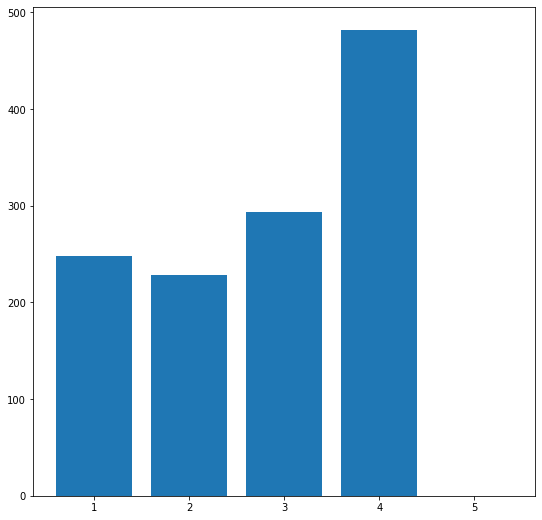

In [16]:
import matplotlib.pyplot as plt
names = ['1', '2', '3', '4', '5']
values = [248, 228, 294, 482, 0]
plt.figure(figsize=(9,9))
plt.bar(names, values)
plt.show()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
w, h = 5, 2000;
Sim_score_Matrix = ([[-200 for x in range(w)] for y in range(h)]) 
z_Matrix = ([[0 for x in range(w)] for y in range(h)]) 
img_Matrix = ([[-1 for x in range(w)] for y in range(h)])


z_points_2 = ae.encoder.predict(example_images_2)
z=cosine_similarity(z_points_2,m)
#print(z.shape)

for i in range(2000):
    for l in range(5):
        if(z[i].max()>=0.98):
            k=z[i].argmax()
            z[i][k]=0
        elif(z[i].max()<0.98 and z[i].max()>0.8):
        #if(z[i].max()>Sim_score_Matrix[i][l]):
            Sim_score_Matrix[i][l]=z[i].max()
            #z_Matrix[i][l]=z_points_2[z[i].argmax()]
            img_Matrix[i][l]=z[i].argmax()
            k=z[i].argmax()
            z[i][k]=0

In [18]:
print(z.shape)

(2000, 181858)


In [19]:
print(RUN_FOLDER)

/home/pytorch_ashish/deep_learning/data/alt_text_data_all/models/grey/AE-100epochs/


In [20]:
print(source_images.shape, image_dataframe.shape)

(2000, 5) (181858, 5)


In [21]:
image_dataframe.head()

,Unnamed: 0,Name,Path,Height,Width
0,0,9781337111348_11348_ch02_2.1_017-t2.png,/home/pytorch_ashish/deep_learning/data/alt_te...,131,181
1,1,9781285194790_9781285194790-551-t2.png,/home/pytorch_ashish/deep_learning/data/alt_te...,550,593
2,2,9781133947257_9781133947257_ch01_65-t2.png,/home/pytorch_ashish/deep_learning/data/alt_te...,101,184
3,3,9781305652231_52231_ch01_f022-t2.png,/home/pytorch_ashish/deep_learning/data/alt_te...,24,188
4,4,ceng_image205.png,/home/pytorch_ashish/deep_learning/data/alt_te...,131,268


# Alt Text Data

In [22]:
image_dataframe=pd.read_csv('/home/pytorch_ashish/deep_learning/data/alt_text_data_all/image_location_venky.csv')
cengage= pd.read_csv('/home/pytorch_ashish/deep_learning/data/alt_text_data_all/cengage_production_data.csv')
pearson= pd.read_csv('/home/pytorch_ashish/deep_learning/data/alt_text_data_all/pearson_production_data.csv')
wiley=pd.read_csv('/home/pytorch_ashish/deep_learning/data/alt_text_data_all/wiley_production_data.csv')
wiley.rename(columns={'image_names':'Name'}, inplace=True)
pearson.rename(columns={'image_names':'Name'}, inplace=True)
cengage.rename(columns={'image_names':'Name'}, inplace=True)

In [6]:
import pandas as pd
cengage= pd.read_csv('/home/pytorch_ashish/deep_learning/data/alt_text_data_all/cengage_production_data.csv')
cengage.head()
pd.unique(cengage[['subject_area']].values.ravel('K'))
cengage['subject_area'].value_counts()

other                   38344
maths                   13844
science                  3288
engineering              1854
history                  1014
agriculture, science      848
law, business             784
accounting                612
business                  561
law                       536
computer                  513
language                  375
economics, math           130
psychology                112
computer, business         94
economics                  63
business, language         55
Name: subject_area, dtype: int64

In [23]:
image_dataframe.shape

(181858, 5)

In [24]:
image_dataframe=pd.merge(image_dataframe, cengage, on='Name', how='left')
image_dataframe.drop(['image_path', 'alt_text_html', 'Unnamed: 0'], axis=1, inplace=True)

image_dataframe=pd.merge(image_dataframe, pearson, on='Name', how='left')
image_dataframe["alt_text"] = image_dataframe["alt_text_x"].astype(str) + " "+image_dataframe["alt_text_y"].astype(str)
image_dataframe['subject_area'] = image_dataframe['subject_area_x'].astype(str) + " "+ image_dataframe['subject_area_y'].astype(str)
image_dataframe.drop(['alt_text_x', "alt_text_y", 'subject_area_x', 'subject_area_y', 'alt_text_html', 'image_path'], axis=1, inplace=True)

image_dataframe=pd.merge(image_dataframe, wiley, on='Name', how='left')
image_dataframe["alt_text"] = image_dataframe["alt_text_x"].astype(str) + " "+ image_dataframe["alt_text_y"].astype(str)
image_dataframe['subject_area'] = image_dataframe['subject_area_x'].astype(str) + " "+ image_dataframe['subject_area_y'].astype(str)
image_dataframe.drop(['alt_text_x', "alt_text_y", 'subject_area_x', 'subject_area_y', 'alt_text_html', 'image_path'], axis=1, inplace=True)



In [25]:
image_dataframe.head()

,Name,Path,Height,Width,alt_text,subject_area
0,9781337111348_11348_ch02_2.1_017-t2.png,/home/pytorch_ashish/deep_learning/data/alt_te...,131,181,The image consists of a Minitab output. Visual...,maths nan nan
1,9781285194790_9781285194790-551-t2.png,/home/pytorch_ashish/deep_learning/data/alt_te...,550,593,A map shows the Second Iraq War. Majority popu...,history nan nan
2,9781133947257_9781133947257_ch01_65-t2.png,/home/pytorch_ashish/deep_learning/data/alt_te...,101,184,In the Sherlock Holmes mystery The Final Solut...,maths nan nan
3,9781305652231_52231_ch01_f022-t2.png,/home/pytorch_ashish/deep_learning/data/alt_te...,24,188,The image consists of a number line. The numbe...,maths nan nan
4,ceng_image205.png,/home/pytorch_ashish/deep_learning/data/alt_te...,131,268,The image consists of a visual representation ...,maths nan nan


In [26]:
image_dataframe.shape

(181858, 6)

In [27]:
image_dataframe.isna().sum()

Name            0
Path            0
Height          0
Width           0
alt_text        0
subject_area    0
dtype: int64

In [28]:
source_images=pd.merge(source_images, image_dataframe, on='Name', how='left')
source_images.drop(['Path_y', "Height_y", 'Width_y', 'Unnamed: 0'], axis=1, inplace=True)

In [29]:
source_images.shape

(2000, 6)

In [30]:
source_images.head()

,Name,Path_x,Height_x,Width_x,alt_text,subject_area
0,9780134838076_unfig17-10.png,/home/pytorch_ashish/deep_learning/data/alt_te...,335,387,nan Product design A proceeds as follows from ...,nan canada nan
1,0321613376_p101_002.jpg,/home/pytorch_ashish/deep_learning/data/alt_te...,100,439,nan Multiplying by 6 on both sidesUsing the di...,nan maths nan
2,0321916603_pA-32_005.jpg,/home/pytorch_ashish/deep_learning/data/alt_te...,194,184,nan The graph of x213+y29= 1is an ellipse cent...,nan maths nan
3,0321955048_pA20_018.jpg,/home/pytorch_ashish/deep_learning/data/alt_te...,184,154,nan A tree diagram with 16 outcomes. Branches ...,nan maths nan
4,032182623X_p428_001.jpg,/home/pytorch_ashish/deep_learning/data/alt_te...,188,560,nan Two-Sample T-Test for SUCCESSGROUPNMeanStD...,nan maths nan


In [31]:
print(RUN_FOLDER)

/home/pytorch_ashish/deep_learning/data/alt_text_data_all/models/grey/AE-100epochs/


In [173]:
RESULT_IMAGE=RUN_FOLDER+'/Test_sc_0.8_0.98_trunc_text/'#.format(i)
filename2='similar_image_'+str(2)+'.txt'
file1=open(os.path.join(RESULT_IMAGE,filename2), "w")
alt_text=image_dataframe['alt_text'][0]
file1.write(alt_text+" \n")
file1.close() 

In [36]:
#load_image=pd.read_csv('image_location.csv')
import cv2
for i in range(2000):
    RESULT_IMAGE=RUN_FOLDER+'/Test_sc_0.8_0.98_trunc_text/{}/'.format(i)
    for k in range(5):
        if(img_Matrix[i][k]!=-1):
            if not os.path.exists(RESULT_IMAGE):
                os.mkdir(RESULT_IMAGE)
            similar_img=cv2.imread(image_dataframe['Path'][img_Matrix[i][k]],0)
            alt_text=image_dataframe['alt_text'][img_Matrix[i][k]].encode('utf-8')      #image_dataframe has all the images
            score=round(Sim_score_Matrix[i][k], 3)
            filename='similar_image_'+str(k)+'__'+str(score)+'.jpg'
            cv2.imwrite(os.path.join(RESULT_IMAGE,filename), similar_img)

            filename2='similar_image_'+str(k)+'.txt'
            file1=open(os.path.join(RESULT_IMAGE,filename2), "w")
            file1.write(str(alt_text)+" \n")
            file1.close()
    if os.path.exists(RESULT_IMAGE):
        img = cv2.imread(source_images['Path_x'][i],0)   #source_images has random 100 image
        filename='original_image_'+str(i)+'.jpg'
        cv2.imwrite(os.path.join(RESULT_IMAGE,filename), img)

        alt_text_2=str(source_images['alt_text'][i]).encode('utf-8')
        filename2='original_image_'+str(i)+'.txt'
        file1=open(os.path.join(RESULT_IMAGE,filename2), "w")
        file1.write(str(alt_text_2)+" \n")
        file1.close()

In [2]:
round(0.9999999999999,3)

1.0

In [63]:
RESULT_IMAGE=RUN_FOLDER+'/Test_sc_0.8_0.9_trunc/0/'
if os.path.exists(RESULT_IMAGE):
    print(True)